In [21]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_20368/2891261325.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create and prepare the data

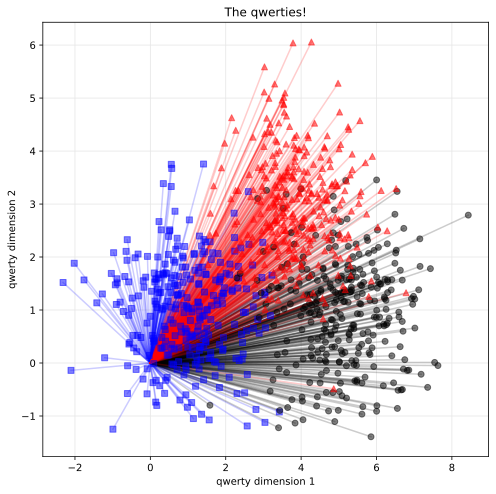

In [5]:
# Parameters
n_per_clust = 300
blur        = 1
A           = [1, 1]
B           = [5, 1]
C           = [4, 3]

# Generate data
a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

# Concatanate into a matrix
data_np   = np.hstack(tup=(a, b, c)).T

# True labels
labels_np = np.hstack(tup=(np.zeros(shape=(n_per_clust)), 
                           np.ones(shape=(n_per_clust)),
                           1 + np.ones(shape=(n_per_clust))))

# Convert to a pytorch tensor
data   = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# Show the data
fig = plt.figure(figsize=(8, 8))

# Draw distance to origin
color = 'bkr'
for i in range(len(data)):
    plt.plot([0, data[i, 0]], [0, data[i, 1]], color=color[labels[i]], alpha=0.2)

plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs', alpha=0.5)
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko', alpha=0.5)
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], 'r^', alpha=0.5)

plt.grid(color=[0.9, 0.9, 0.9])
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

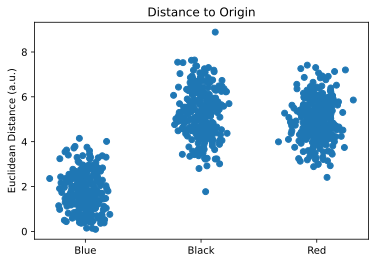

In [19]:
# Compute Euclidean distance to the origin
dist_2_orig = torch.sqrt((data[:, 0] ** 2) + (data[:, 1] ** 2))

plt.plot(labels + torch.randn(900) / 10, dist_2_orig, 'o')
plt.xticks([0, 1, 2], labels=['Blue', 'Black', 'Red'])
plt.ylabel('Euclidean Distance (a.u.)')
plt.title('Distance to Origin')
plt.show()

In [20]:
# Add that to the data matrix
# `.view(len(data)` -> Convert to column vector
data_aug = torch.cat((data, dist_2_orig.view(len(data), 1)), axis=1)

# Check data sizes
print(data.shape)
print(data_aug.shape)
print('')

# Look at some of the data
print(data_aug)

torch.Size([900, 2])
torch.Size([900, 3])

tensor([[0.8946, 0.9520, 1.3064],
        [0.1474, 1.1117, 1.1214],
        [0.2801, 1.3316, 1.3607],
        ...,
        [4.5851, 0.8346, 4.6604],
        [3.8085, 2.1413, 4.3692],
        [3.0284, 5.5884, 6.3562]])


In [22]:
#  Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = \
    train_test_split(data_aug, labels, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 16
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])

# Create the model

In [23]:
def create_the_qwety_net(use_extra_feature=False):
    class qwerty_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            if use_extra_feature:
                self.input = nn.Linear(3, 8)
            else:
                self.input = nn.Linear (2, 8)

            # Hidden layer
            self.fc1 = nn.Linear(8, 8)

            # Output layer
            self.output = nn.Linear(8, 3)

        # Forward pass
        def forward(self, x):

            # By requeset, only use XY features
            if not use_extra_feature:
                x = x[:, :2]

            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = self.output(x)

            return x
        
    # Create the model instance
    net = qwerty_net()
    
    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.001)


    return net, loss_func, optimizer

In [27]:
# Test the model

print('Using augmented feature:')
net = create_the_qwety_net(use_extra_feature=True)[0]
net(next(iter(train_loader))[0]);

print('Not Using augmented feature:')
net = create_the_qwety_net(use_extra_feature=False)[0]
net(next(iter(train_loader))[0]);

Using augmented feature:
Not Using augmented feature:


In [28]:
def train_the_model(use_extra_feature=False):
  """
  DATA_DATA_FEATURE_AUGMENTATION
  """
  num_epochs = 200

  net, loss_func, optimizer = create_the_qwety_net(use_extra_feature)

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    with torch.no_grad():           # Deactivates autograd
      y_hat = net(X)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

  # Function output
  return train_acc, test_acc, losses, net

# A function that plots the results

In [29]:
def plot_the_results():
    # Compute accuracy over entire dataset (train + test)
    y_hat       = net(data_aug)
    predictions = torch.argmax(y_hat, axis=1)
    accuracy    = (predictions == labels).float()

    # Accuracy by group
    accuracy_by_group = np.zeros(3)
    for i in range(3):
        accuracy_by_group[i] = 100 * torch.mean(accuracy[labels == i])
    
    # Create the figure
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))

    # Plot  the loss function
    ax[0, 0].plot(losses.detach())
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_title('Losses')

    # Plot the accuracy function
    ax[0, 1].plot(train_acc, label='Train')
    ax[0, 1].plot(test_acc,  label='Test')
    ax[0, 1].set_ylabel('Accuracy (%)')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_title('Accuracy')
    ax[0, 1].legend()

    # Plot overall accuracy by group
    ax[1, 0].bar(range(3), accuracy_by_group)
    ax[1, 0].set_ylim([np.min(accuracy_by_group) - 5, np.max(accuracy_by_group) + 5])
    ax[1, 0].set_xticks([0, 1, 2])
    ax[1, 0].set_xlabel('Group')
    ax[1, 0].set_ylabel('Accuracy (%)')
    ax[1, 0].set_title('Accuracy by group')

    # Scatter plot of correct and incorrect labeled data
    color_shapes = ['bs', 'ko', 'g^'] # Data makers
    for i in range(3):
        # Plot all data points
        ax[1, 1].plot(data_aug[labels == i, 0], data_aug[labels == i, 1], color_shapes[i],
                      alpha=0.3, label=f'Group {i}')

        # Cross-out the incorrect ones
        idx_err = (accuracy == 0) & (labels == i)
        ax[1, 1].plot(data_aug[idx_err, 0], data_aug[idx_err, 1], 'rx')
    
    ax[1, 1].set_title('All groups')
    ax[1, 1].set_xlabel('qwerty dimension 1')
    ax[1, 1].set_ylabel('qwerty dimension 2')
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Test the model with and without the additional feature

Final accuracy: 87.78


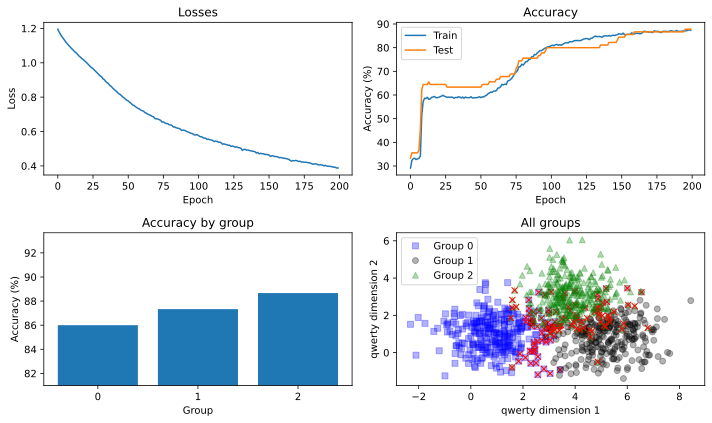

In [31]:
# Run the model and visualize the results
train_acc, test_acc, losses, net = train_the_model(use_extra_feature=False)
print(f'Final accuracy: {test_acc[-1]:.2f}')
plot_the_results()

Final accuracy: 87.78


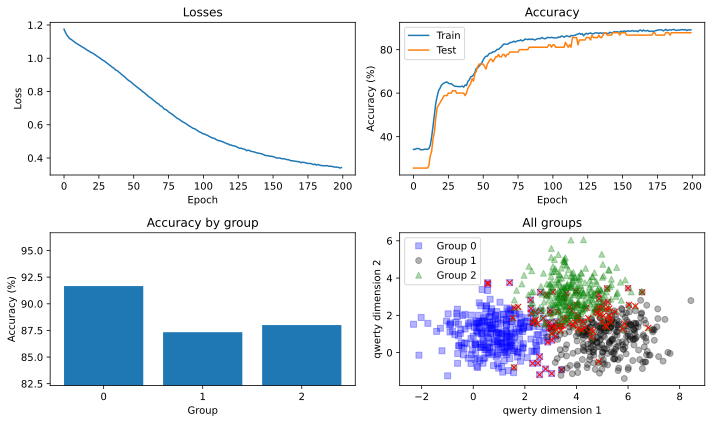

In [32]:
# Run the model and visualize the results
train_acc, test_acc, losses, net = train_the_model(use_extra_feature=True)
print(f'Final accuracy: {test_acc[-1]:.2f}')
plot_the_results()

# Run the experiment!

In [33]:
# Run the exper multiple times and do a t-test

final_acc_2 = np.zeros(10)
final_acc_3 = np.zeros(10)

for i in range(10):
    final_acc_2[i] = train_the_model(use_extra_feature=False)[1][-1]
    final_acc_3[i] = train_the_model(use_extra_feature=True)[1][-1]

# Show the numbers
print(np.round(np.vstack(tup=(final_acc_2, final_acc_3)).T, decimals=2))

# Run the t-test and print the results
t, p = stats.ttest_ind(final_acc_3, final_acc_3)
print(f't = {t:.2f}, p = {p:.2f}')
    

[[88.89 86.67]
 [87.78 86.67]
 [87.78 82.22]
 [84.44 87.78]
 [88.89 86.67]
 [88.89 86.67]
 [86.67 88.89]
 [87.78 85.56]
 [88.89 81.11]
 [90.   87.78]]
t = 0.00, p = 1.00


# Additional explorations

In [16]:
# 1) Add code to the "distance-to-origin" plot (top of the script) so the color and shape of the dots matches those 
#    used in the previous qwerties plot. Also, change the colors of the bars in the barplots to match the qwerties.
# 
# 2) If you increase the learning rate, or increase the number of epochs, or use Adam instead of SGD, you'll find that
#    both datasets lead to equally good -- and high -- performance. Based on the graph of the data, do you think it's
#    even possible to reach 100% accuracy? What does this tell you about ceiling effects in DL?
# 